In [1]:
import spacy
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from community import community_louvain
import matplotlib.cm as cm
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

In [2]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [3]:
model = SentenceTransformer('all-mpnet-base-v2')

In [4]:
df_ai = pd.read_excel("data/powerbi/glossaries_excel/ai.xlsx").dropna()
df_cs = pd.read_excel("data/powerbi/glossaries_excel/cs.xlsx").dropna()
df_stats = pd.read_excel("data/powerbi/glossaries_excel/stats.xlsx").dropna()

df = pd.concat([df_ai, df_cs, df_stats])

In [5]:
bag_of_words = df["description"].values.tolist()
labels_of_words = df["label"].values.tolist()

In [6]:
infered_words = []

def get_adj_mat(method):
    adj_mat = []

    if not infered_words:
        if method == "bert":
            for words in tqdm(bag_of_words):
                infered_words.append(model.encode(words))
        elif method == "spacy":
            for words in tqdm(bag_of_words):
                infered_words.append(nlp(words))

    for words in tqdm(infered_words):
        row = []
        for new_words in infered_words:
            if np.array_equal(words, new_words):
                similarity = 0.0
            else:
                if method == "bert":
                    similarity = util.cos_sim(words, new_words)[0][0].item()
                elif method == "spacy":
                    similarity = words.similarity(new_words)

            row.append(1 if similarity > .3 else 0.0)

        adj_mat.append(row)
    return adj_mat

In [7]:
adjacency_matrix = get_adj_mat(method="bert")

100%|██████████| 629/629 [00:43<00:00, 14.52it/s]


In [8]:
np_adj = np.array(adjacency_matrix)
df_adj = pd.DataFrame(np_adj, columns=labels_of_words, index=labels_of_words)
df_adj.to_csv("data/adj_matrix.csv")

df_adj

abductive logic programming (ALP)  \
abductive logic programming (ALP)                                0.0   
abductive reasoning                                              1.0   
abstract data type                                               1.0   
abstraction                                                      0.0   
action model learning                                            1.0   
...                                                              ...   
upper quartile                                                   0.0   
value                                                            0.0   
variable                                                         0.0   
variance                                                         0.0   
z-score                                                          0.0   

                                   abductive reasoning  abstract data type  \
abductive logic programming (ALP)                  1.0                 1.0   
abductive reasoning                                0.0                 1.0   
abstract data type                                 1.0                 0.0   
abstraction                                        1.0                 1.0   
action model learning                              1.0                 1.0   
...                                                ...                 ...   
upper quartile                                     0.0                 0.0   
value                                              0.0                 1.0   
variable                                           0.0                 1.0   
variance                                           0.0                 1.0   
z-score                                            0.0                 1.0   

                                   abstraction  action model learning  \
abductive logic programming (ALP)          0.0                    1.0   
abductive reasoning                        1.0                    1.0   
abstract data type                         1.0                    1.0   
abstraction                                0.0                    1.0   
action model learning                      1.0                    0.0   
...                                        ...                    ...   
upper quartile                             0.0                    0.0   
value                                      1.0                    0.0   
variable                                   1.0                    0.0   
variance                                   0.0                    0.0   
z-score                                    0.0                    0.0   

                                   action selection  activation function  \
abductive logic programming (ALP)               1.0                  0.0   
abductive reasoning                             1.0                  0.0   
abstract data type                              0.0                  1.0   
abstraction                                     0.0                  0.0   
action model learning                           1.0                  0.0   
...                                             ...                  ...   
upper quartile                                  0.0                  0.0   
value                                           0.0                  0.0   
variable                                        0.0                  0.0   
variance                                        0.0                  0.0   
z-score                                         0.0                  0.0   

                                   adaptive algorithm  admissible heuristic  \
abductive logic programming (ALP)                 0.0                   0.0   
abductive reasoning                               1.0                   0.0   
abstract data type                                1.0                   0.0   
abstraction                                       1.0                   0.0   
action model learning                           

In [15]:
G = nx.from_numpy_array(np_adj)
pos = nx.spring_layout(G, k=.25, weight=100)
partition = community_louvain.best_partition(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

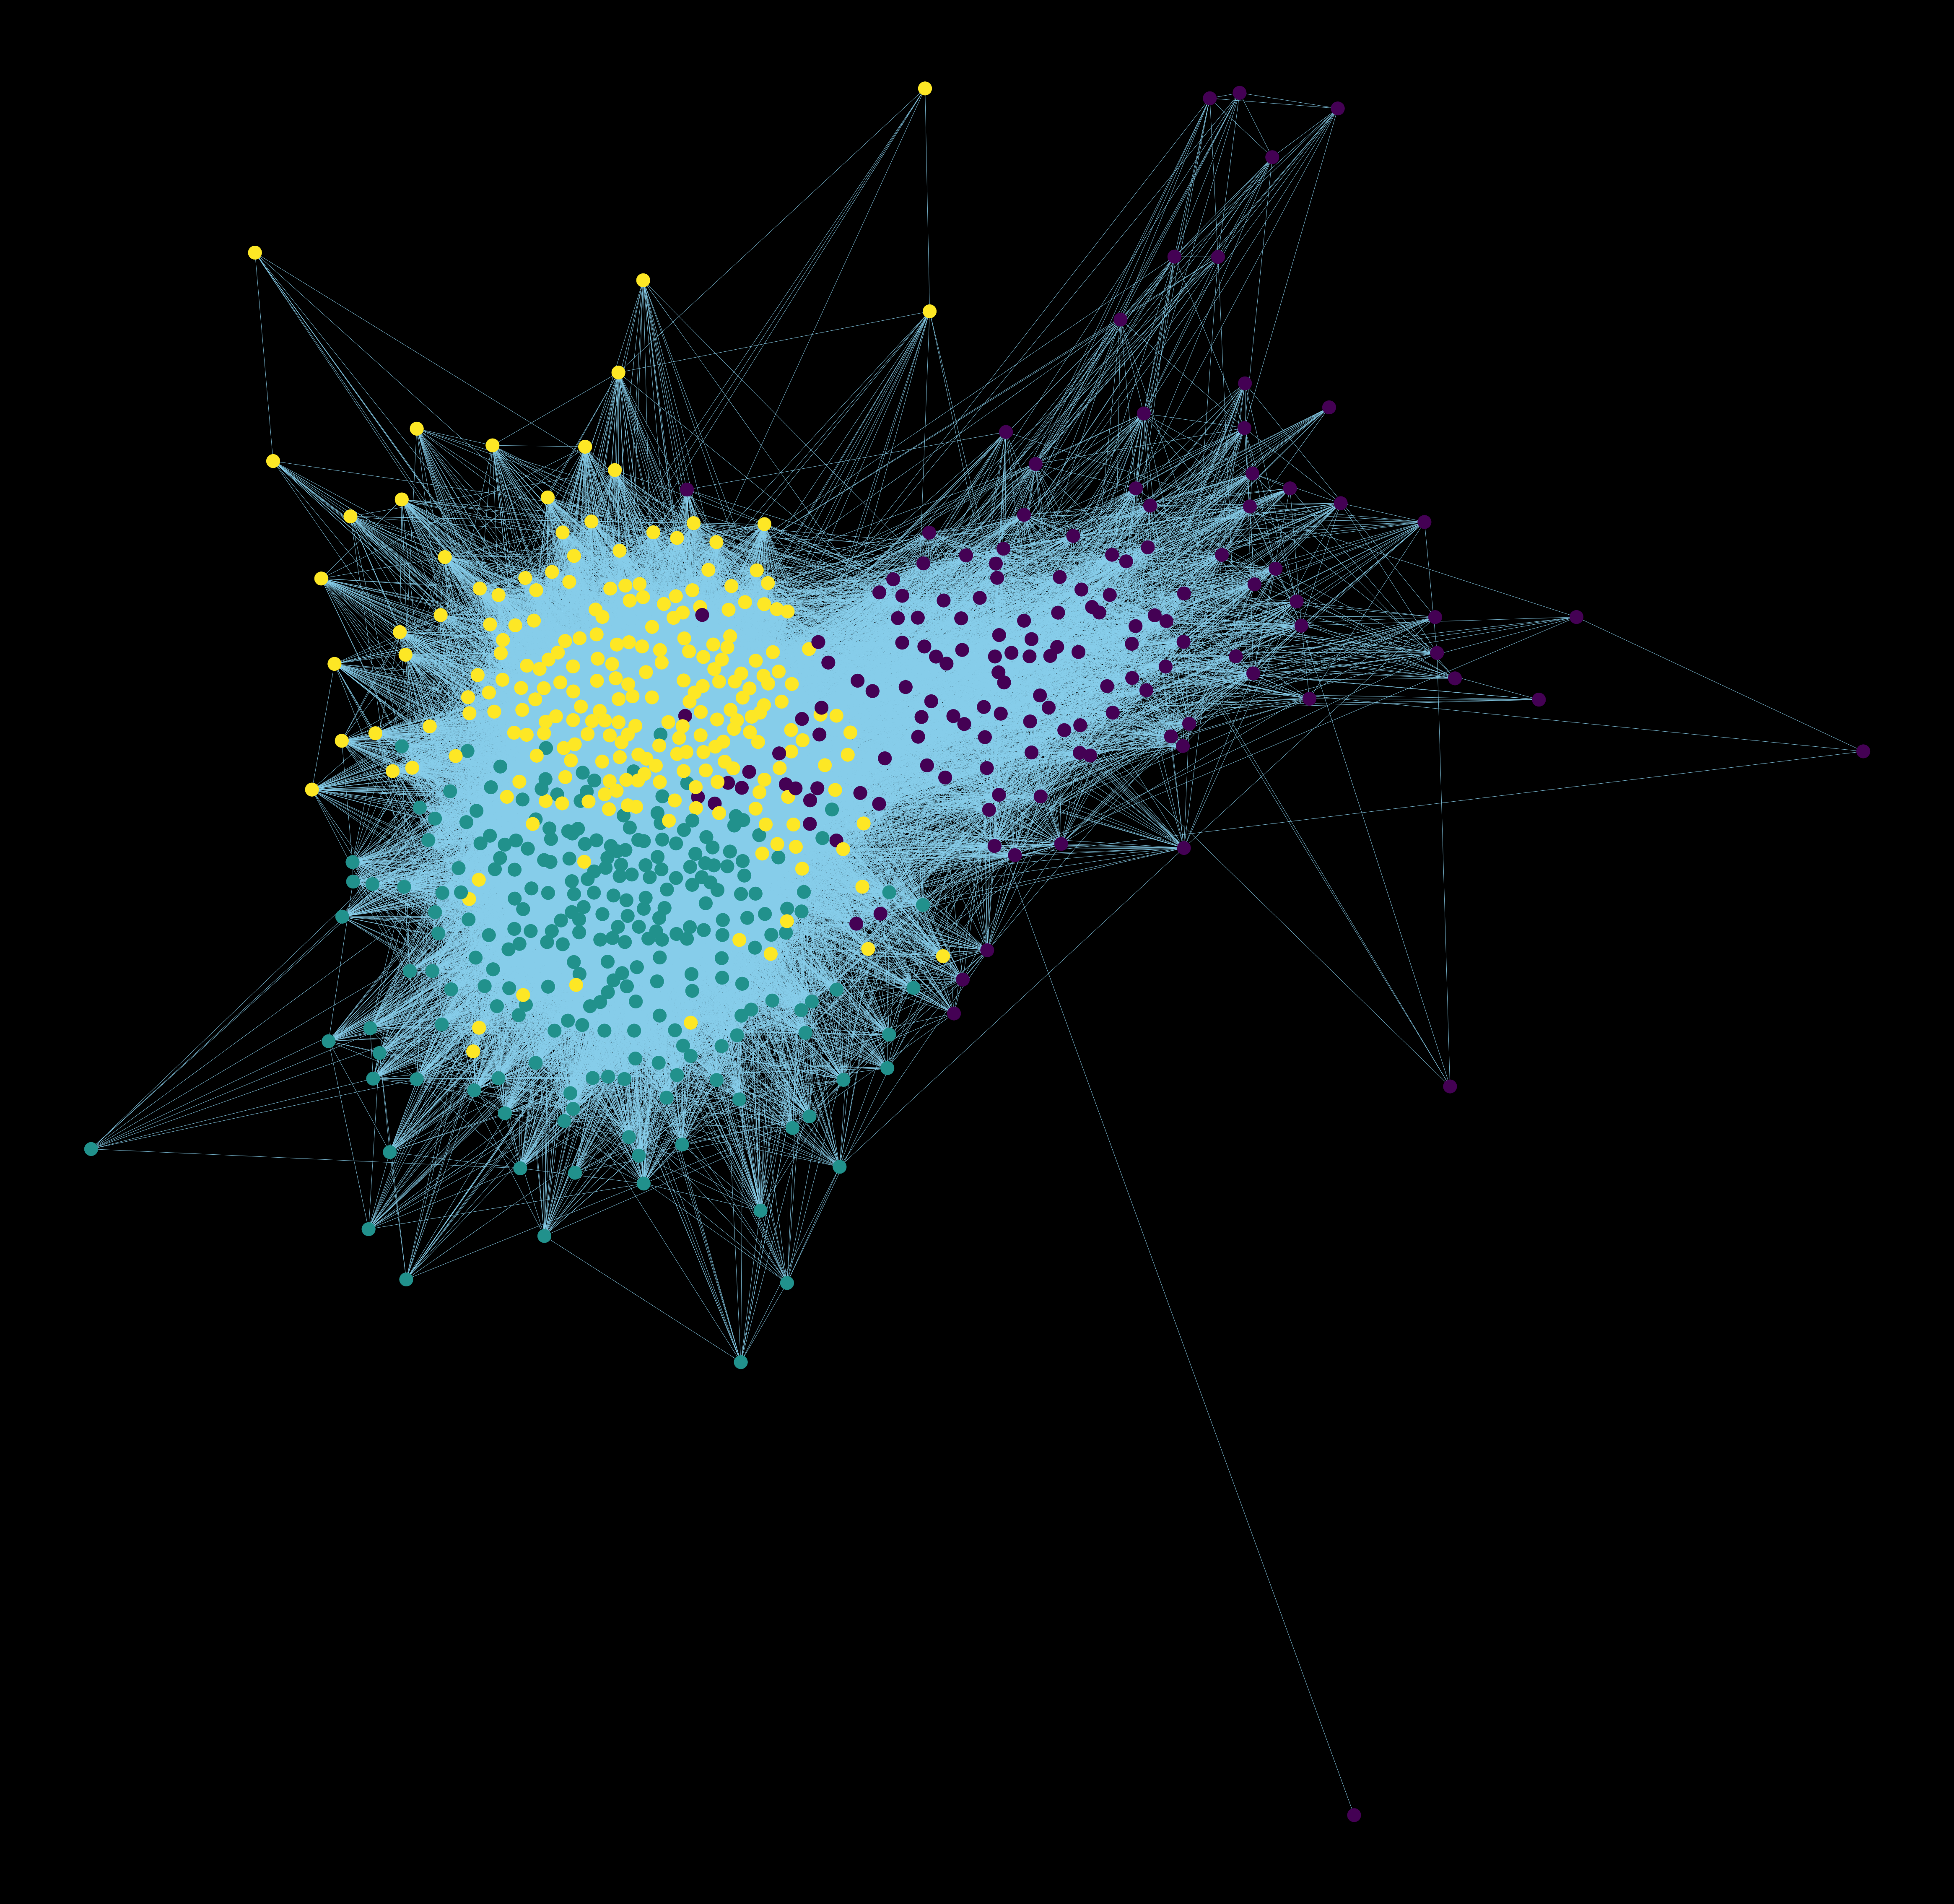

In [29]:
fig, ax = plt.subplots(figsize=(100, 100), dpi=60)
fig.set_facecolor("black")
ax.axis('off')
fig.set_facecolor('black')

# Set the argument "with labels" to False so you have unlabeled graph
nx.draw_networkx(G, pos, partition.keys(), with_labels=False, cmap=cmap, node_color=list(partition.values()), node_size=1500, edge_color='skyblue')

# plt.savefig("data/network.png", format="PNG", transparent=True, facecolor=ax.get_facecolor(), dpi=60)
plt.savefig("data/network.png", format="PNG", transparent=True, dpi=60)